In [21]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

In [22]:
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Stromal/final/"
)

FIG2SAVE = DIR2SAVE.joinpath("figures/forpaper/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [23]:
adata = sc.read_h5ad(
    DIR2SAVE.joinpath("CRC_LM_decon_scvi_hvg_Stromal_clustering_final.h5ad")
)
adata.shape

(786, 2000)

In [24]:
adata.obs.Annotation_scVI_detailed.cat.categories

Index(['C3 iCAF', 'ECM CAF', 'Myofibroblast', 'Pericyte', 'SMC'], dtype='object')

In [25]:
adata.uns["Annotation_scVI_detailed_colors"] = ['#41ab5d', '#fe4fe1', '#4fe1fe', '#4f8afe', '#e1fe4f']

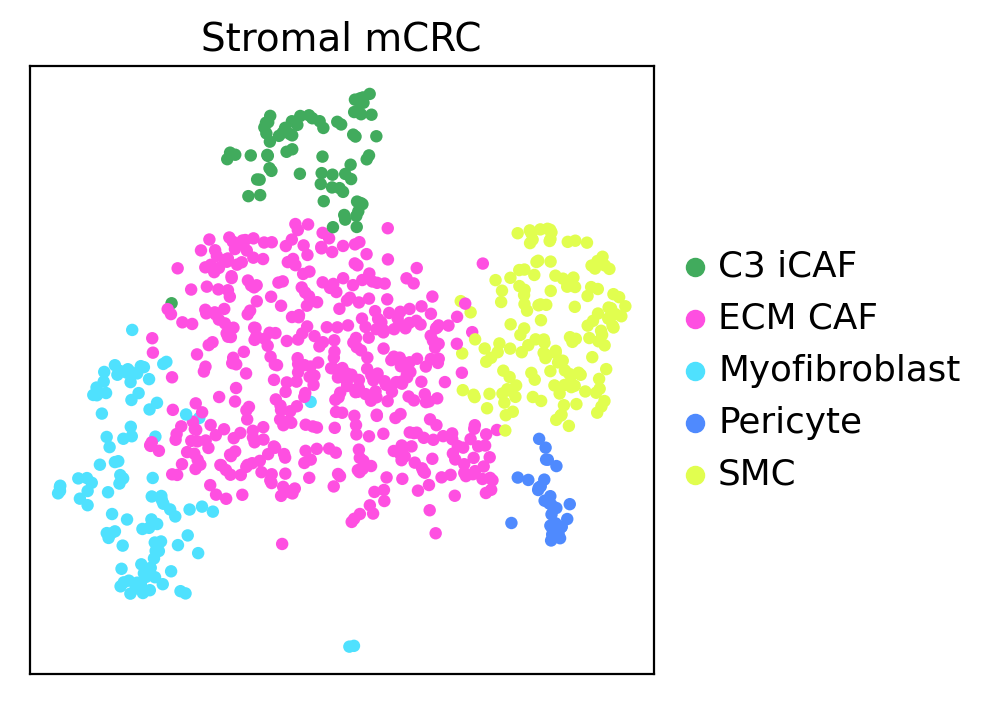

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.umap(
    adata,
    color="Annotation_scVI_detailed",
    show=False,
    legend_loc="right margin",
    title="Stromal mCRC",
    size=80,
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig(FIG2SAVE.joinpath("Annotation.pdf"), bbox_inches='tight', dpi=DPI)

In [27]:
from matplotlib.patches import Rectangle


def proportion_cells_patient(
    adata, groupby_labels, xlabel: str, ylabel: str, colors: dict, figname: str, bbox_to_anchor=(1, 0.8)
):  # colors
    # compute proportion of cells within each group
    table2plot = (
        adata.reset_index()
        .groupby(groupby_labels)
        .size()
        .groupby(level=0)
        .apply(lambda x: x * 100 / x.sum())
        .unstack()
    )

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        sharey=False,
        sharex=False,
        dpi=DPI,
    )  # figsize=(4, 4))

    print(table2plot)
    table2plot.plot.barh(stacked=True, ax=ax, color=colors.values())  # , color=colors
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd

    labels = list(colors.keys())
    l = [Rectangle((0, 0), 0, 0, color=color) for color in list(colors.values())]
    ax.legend(
        l,
        labels,
        loc="upper left",
        bbox_to_anchor=bbox_to_anchor, #(1, 0.8),
        facecolor="white",
        edgecolor="white",
        ncol=1,
        borderaxespad=0.0,
        framealpha=0,
        frameon=False,
    )

    plt.savefig(FIG2SAVE.joinpath(figname), dpi=DPI, format="pdf", bbox_inches="tight")
    plt.show()

cell_source               BCI-Nuclei  Che-Cells
Annotation_scVI_detailed                       
C3 iCAF                    61.971831  38.028169
ECM CAF                    83.900227  16.099773
Myofibroblast              74.257426  25.742574
Pericyte                   90.000000  10.000000
SMC                        23.076923  76.923077


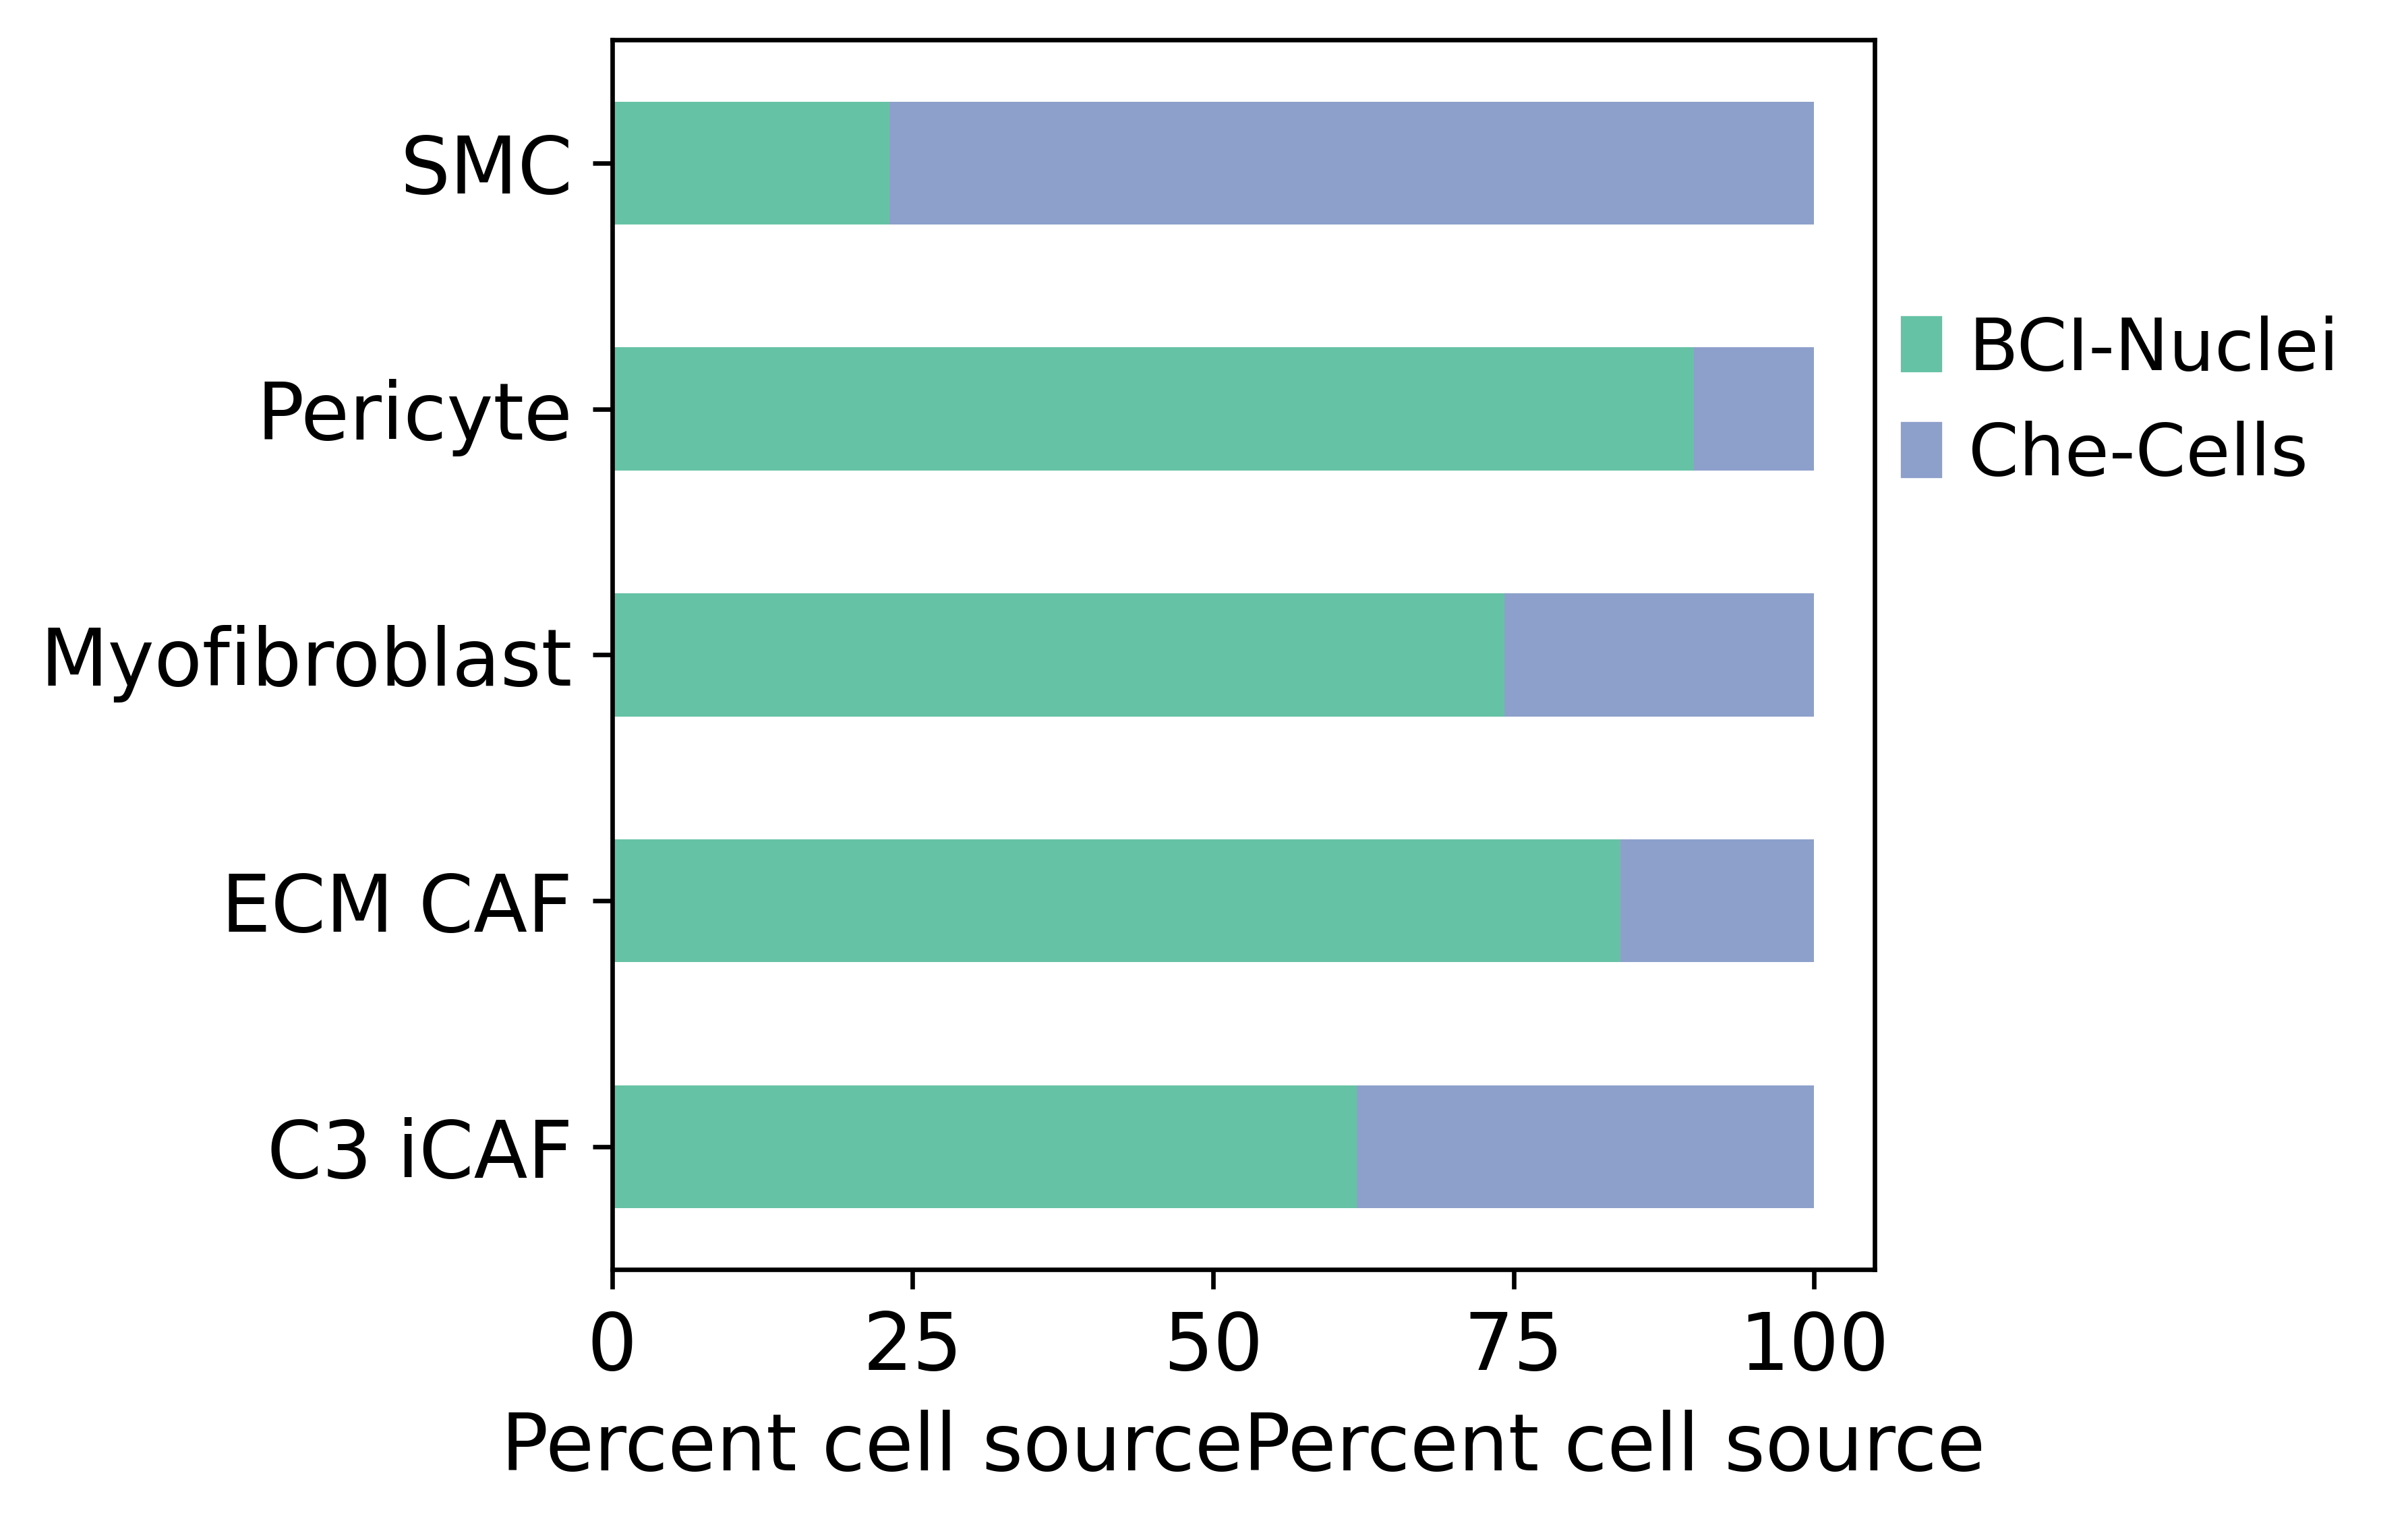

In [28]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["cell_source"].cat.categories.values.tolist(),
        adata.uns["cell_source_colors"],
    )
)

proportion_cells_patient(
    adata.obs,
    groupby_labels=["Annotation_scVI_detailed", "cell_source"],
    xlabel="Percent cell sourcePercent cell source",
    ylabel="",
    colors=color_dict,
    figname="annotation_cell_source.pdf",
)

Annotation_scVI_detailed    C3 iCAF    ECM CAF  Myofibroblast  Pericyte  \
cell_source                                                               
BCI-Nuclei                 8.014572  67.395264      13.661202  4.918033   
Che-Cells                 11.392405  29.957806      10.970464  1.265823   

Annotation_scVI_detailed        SMC  
cell_source                          
BCI-Nuclei                 6.010929  
Che-Cells                 46.413502  


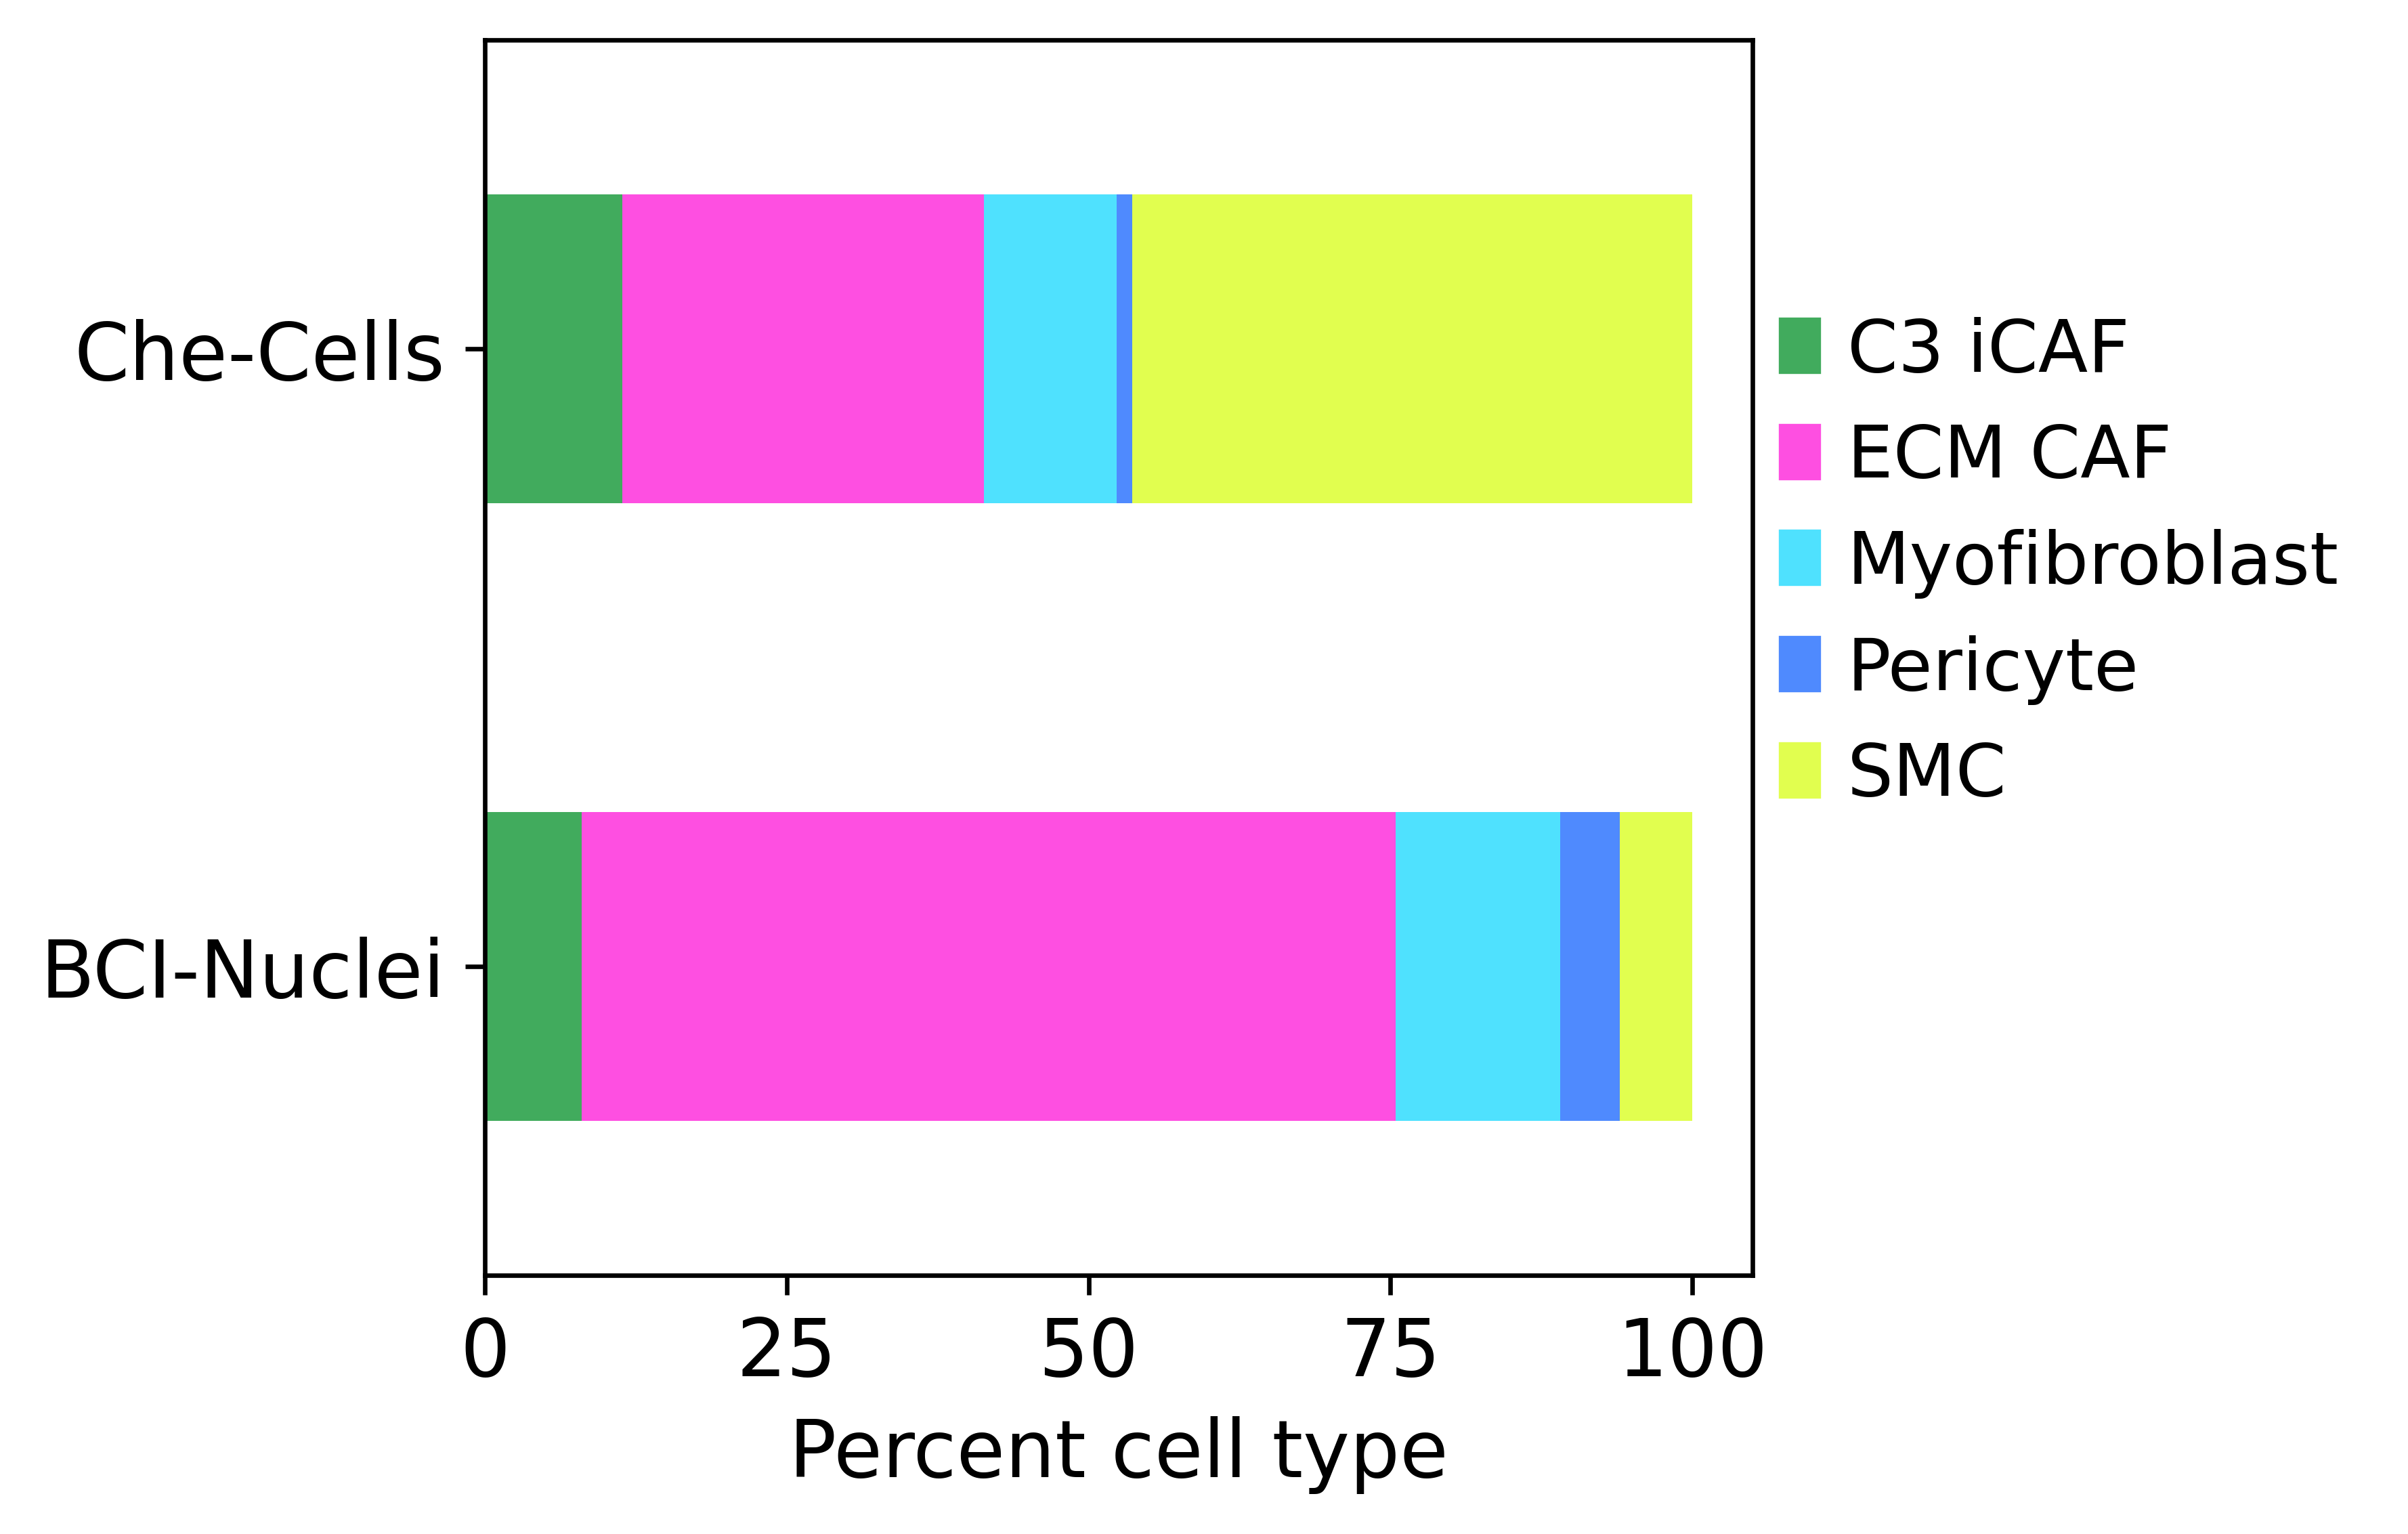

In [29]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["Annotation_scVI_detailed"].cat.categories.values.tolist(),
        adata.uns["Annotation_scVI_detailed_colors"],
    )
)

proportion_cells_patient(
    adata.obs,
    groupby_labels=["cell_source", "Annotation_scVI_detailed"],
    xlabel="Percent cell type",
    ylabel="",
    colors=color_dict,
    figname="barplot_annotation_across_cell_source.pdf",
)

In [30]:
# markers Stromal not Fibro 
markers_stroma_not_caf = {
    #"Enteric glial": ["S100B", "PLP1"],
    "Pericyte": ["PDGFRB", "RGS5", "TAGLN", "ACTA2", "ABCC9"],
    "SMC": ["TAGLN", "ACTA2", "MYH11", "DES"],  # smooth muscle cell
    #"Cycling" : ["MKI67"]
    #"CCL8": ["CCL8", "TGFB1", "IL34", "C2", "CCL13", "CXCL14", "APOE", "CCL2"],
}
# markers for fibro type
markers_specific_caf = {
    "Myofibro": ["TAGLN", "ACTA2", "COL1A1"],
   # "Fibro": ["COL3A1", "DCN", "THY1", "SRPX", "C7"],
    "CAF": ["FAP", "PDPN", "PDGFRA"],
   # "Inflammatory": ["IL6", "IL11", "PDGFRA"],
    "Immune-regulatory": ["CXCL12", "CXCL14"],
    "C3 CD34 iCAF": [
        "C3",
        "CD34",
        "CXCL12",
        "CFB",
        "SERPING1",
        "SFRP1",
        "SFRP2",
        "FBLN5",
        "RSPO3",
        "TGFBR3",
    ],
    "CXCL14 BMP": [
        "CXCL14",
        "BMP4",
        "BMP5",
        "WNT4",
        "BMP7",
        "PDGFRA",
        "C2",
        "CSF1",
        "TGFBR2",
    ],
    #"GREM1": ["GREM1", "SFRP4", "VCAN"],
    "MMP": [
        "MMP3",
        "MMP1",
        "CXCL5",
        "CXCL13",
        "CXCL6",
        "MMP9",
        "MMP13",
        "CXCL1",
        "CXCL8",
        "COL7A1",
        "BAMBI",
        "IL6",
        "IL11",
        "TGFBR1",
    ]
}

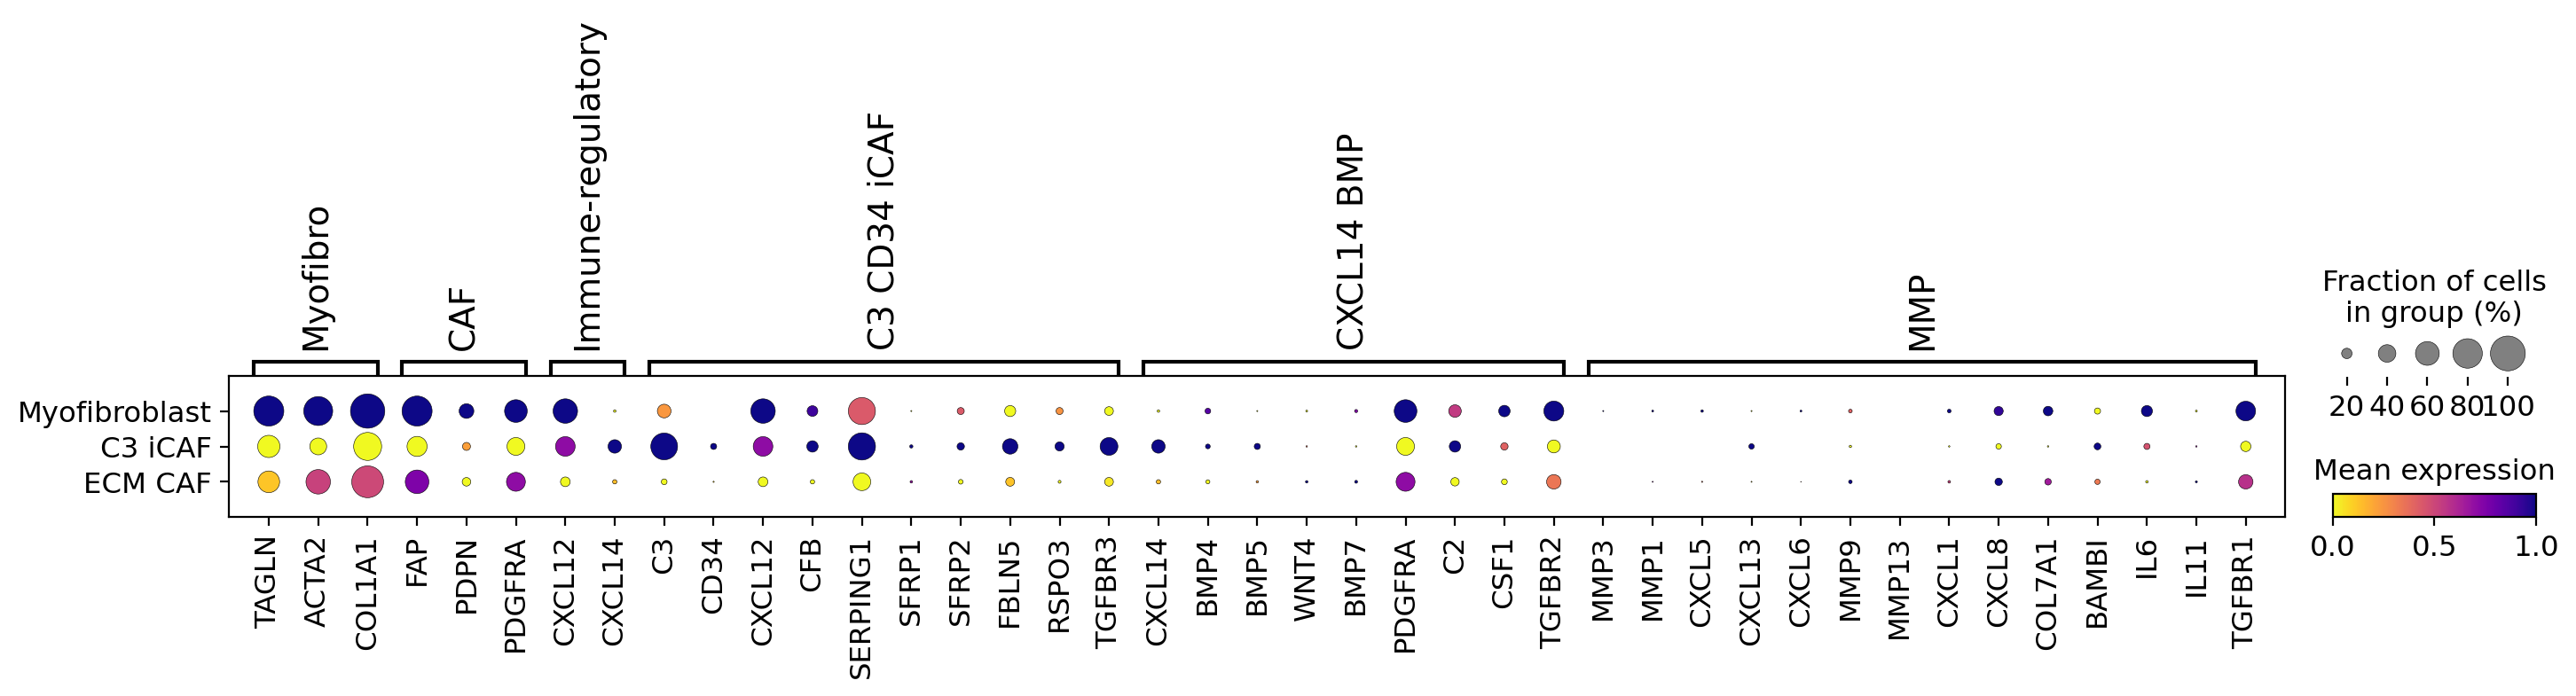

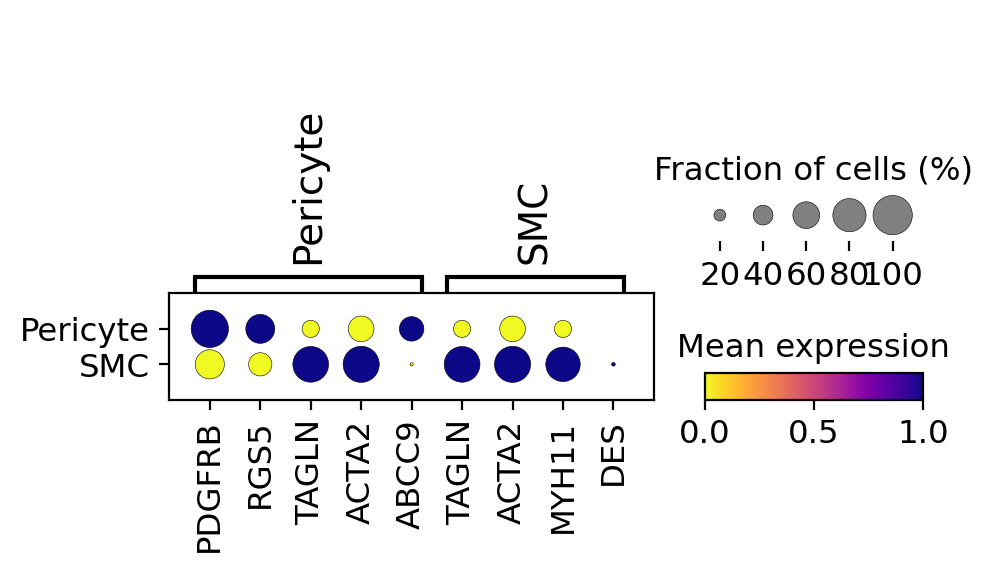

In [31]:
sc.pl.dotplot(
    adata[adata.obs.Annotation_scVI_detailed.str.contains("CAF|Myofibroblast")],
    groupby="Annotation_scVI_detailed",
    use_raw=True,
    var_names=markers_specific_caf,
    categories_order=["Myofibroblast", "C3 iCAF", 
                      "ECM CAF"
                     ],
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    dendrogram=False,
    save="Stromal_dotplot_mean_CAF_annotations.pdf",
    show=True,
)

sc.pl.dotplot(
    adata[~adata.obs.Annotation_scVI_detailed.str.contains("CAF|Myofibroblast")],
    groupby="Annotation_scVI_detailed",
    use_raw=True,
    var_names=markers_stroma_not_caf,
    categories_order=["Pericyte", "SMC"
                     ],
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    size_title="Fraction of cells (%)",
    dendrogram=False,
    save="Stromal_dotplot_mean_Pericyte_SMC_cycling_annotations.pdf",
    show=True,
)

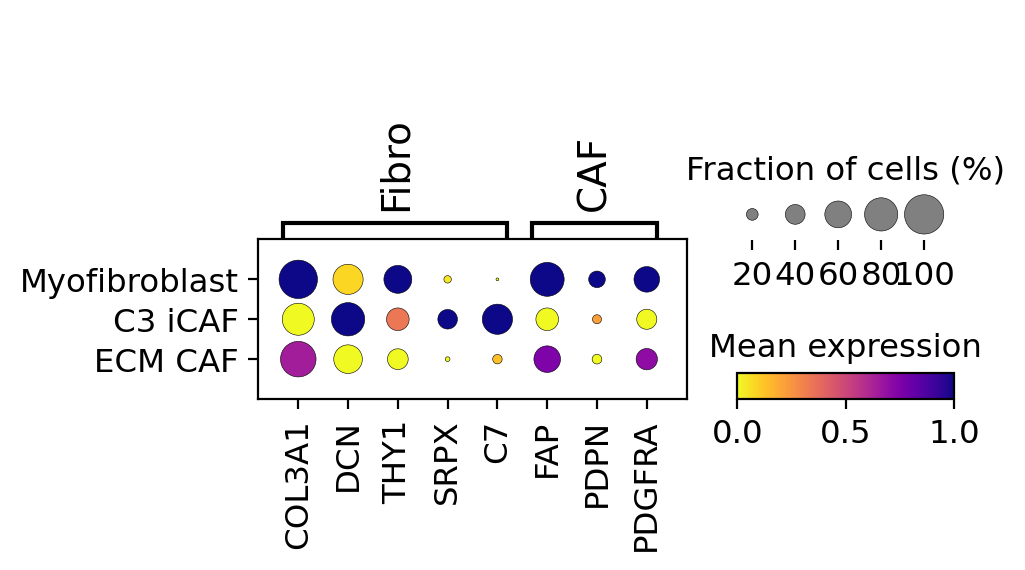

In [32]:
fibro_markers = {
"Fibro": ["COL3A1", "DCN", "THY1", "SRPX", "C7"],
"CAF": ["FAP", "PDPN", "PDGFRA"]
}
sc.pl.dotplot(
    adata[adata.obs.Annotation_scVI_detailed.str.contains("CAF|Myofibroblast")],
    groupby="Annotation_scVI_detailed",
    use_raw=True,
    var_names=fibro_markers,
    categories_order=["Myofibroblast", "C3 iCAF", 
                      "ECM CAF"
                     ],
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    size_title="Fraction of cells (%)",
    dendrogram=False,
    save="Stromal_dotplot_mean_fibro_markers.pdf",
    show=True,
)

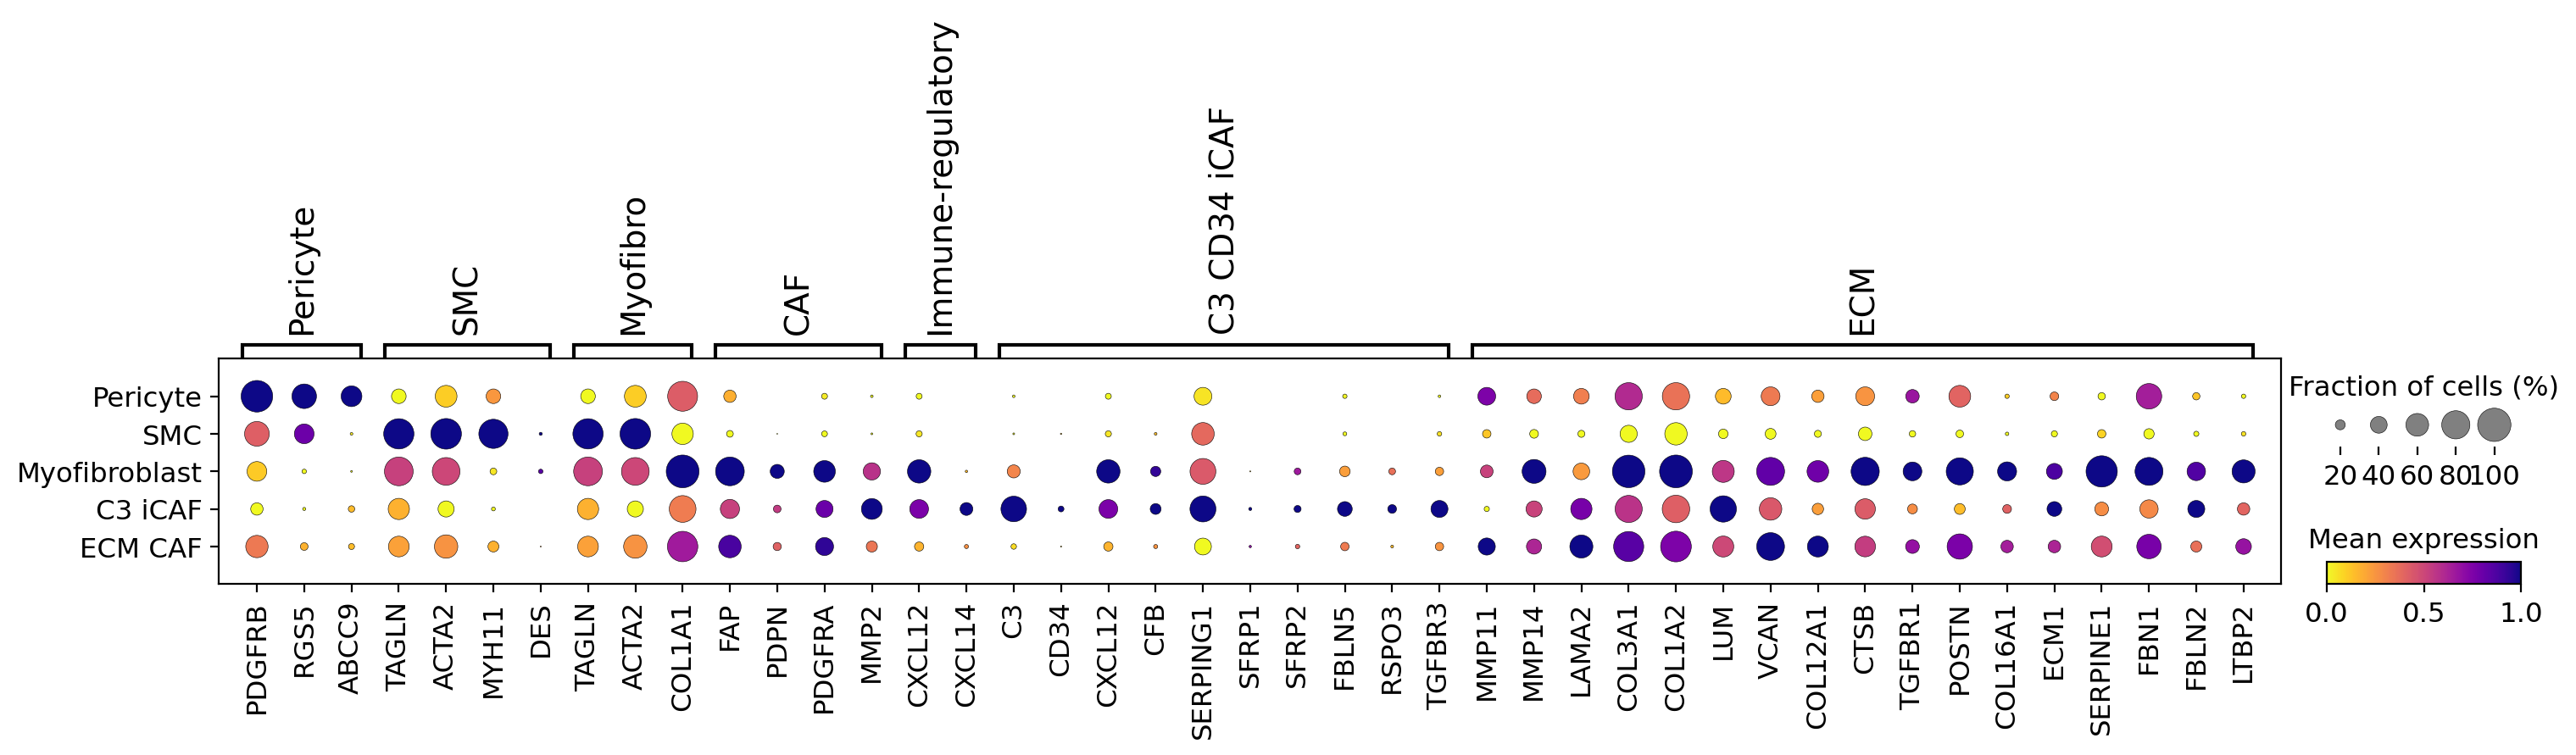

In [33]:
# markers Stromal not Fibro 
markers = {
    #"Enteric glial": ["S100B", "PLP1"],
    "Pericyte": ["PDGFRB", "RGS5", "ABCC9"], # "TAGLN", "ACTA2",
    "SMC": ["TAGLN", "ACTA2", "MYH11", "DES"],  # smooth muscle cell
    #"Cycling" : ["MKI67"]
    #"CCL8": ["CCL8", "TGFB1", "IL34", "C2", "CCL13", "CXCL14", "APOE", "CCL2"],
    "Myofibro": ["TAGLN", "ACTA2", "COL1A1"],
   # "Fibro": ["COL3A1", "DCN", "THY1", "SRPX", "C7"],
    "CAF": ["FAP", "PDPN", "PDGFRA", "MMP2"],
   # "Inflammatory": ["IL6", "IL11", "PDGFRA"],
    "Immune-regulatory": ["CXCL12", "CXCL14"],
    "C3 CD34 iCAF": [
        "C3",
        "CD34",
        "CXCL12",
        "CFB",
        "SERPING1",
        "SFRP1",
        "SFRP2",
        "FBLN5",
        "RSPO3",
        "TGFBR3",
    ],
    #"GREM1": ["GREM1", "SFRP4", "VCAN"],
    "ECM": [ "MMP11",
    #"MMP2",
    "MMP14",
    "LAMA2",
    "COL3A1",
    "COL1A2",
    "LUM",
    #"DCN",
    "VCAN",
    "COL12A1",
             "CTSB", "TGFBR1", 
            #"COL7A1", 
            "POSTN", 
            #"PLAU", "WNT5A", 
            "COL16A1", "ECM1", "SERPINE1",
            "FBN1",
            "FBLN2",
            "LTBP2"
            ]
}

sc.pl.dotplot(
    adata,
    groupby="Annotation_scVI_detailed",
    use_raw=True,
    var_names=markers,
    categories_order=["Pericyte", "SMC", "Myofibroblast", "C3 iCAF", "ECM CAF"
                     ],
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    size_title="Fraction of cells (%)",
    dendrogram=False,
    save="Stromal_dotplot_mean_annotations.pdf",
    show=True,
)

### zscore

In [34]:
adata_zscore = adata.raw.to_adata().copy()
# scale and store results in layer for later plotting
adata_zscore.layers['scaled'] = sc.pp.scale(adata_zscore, copy=True).X
adata_zscore.obs=adata.obs

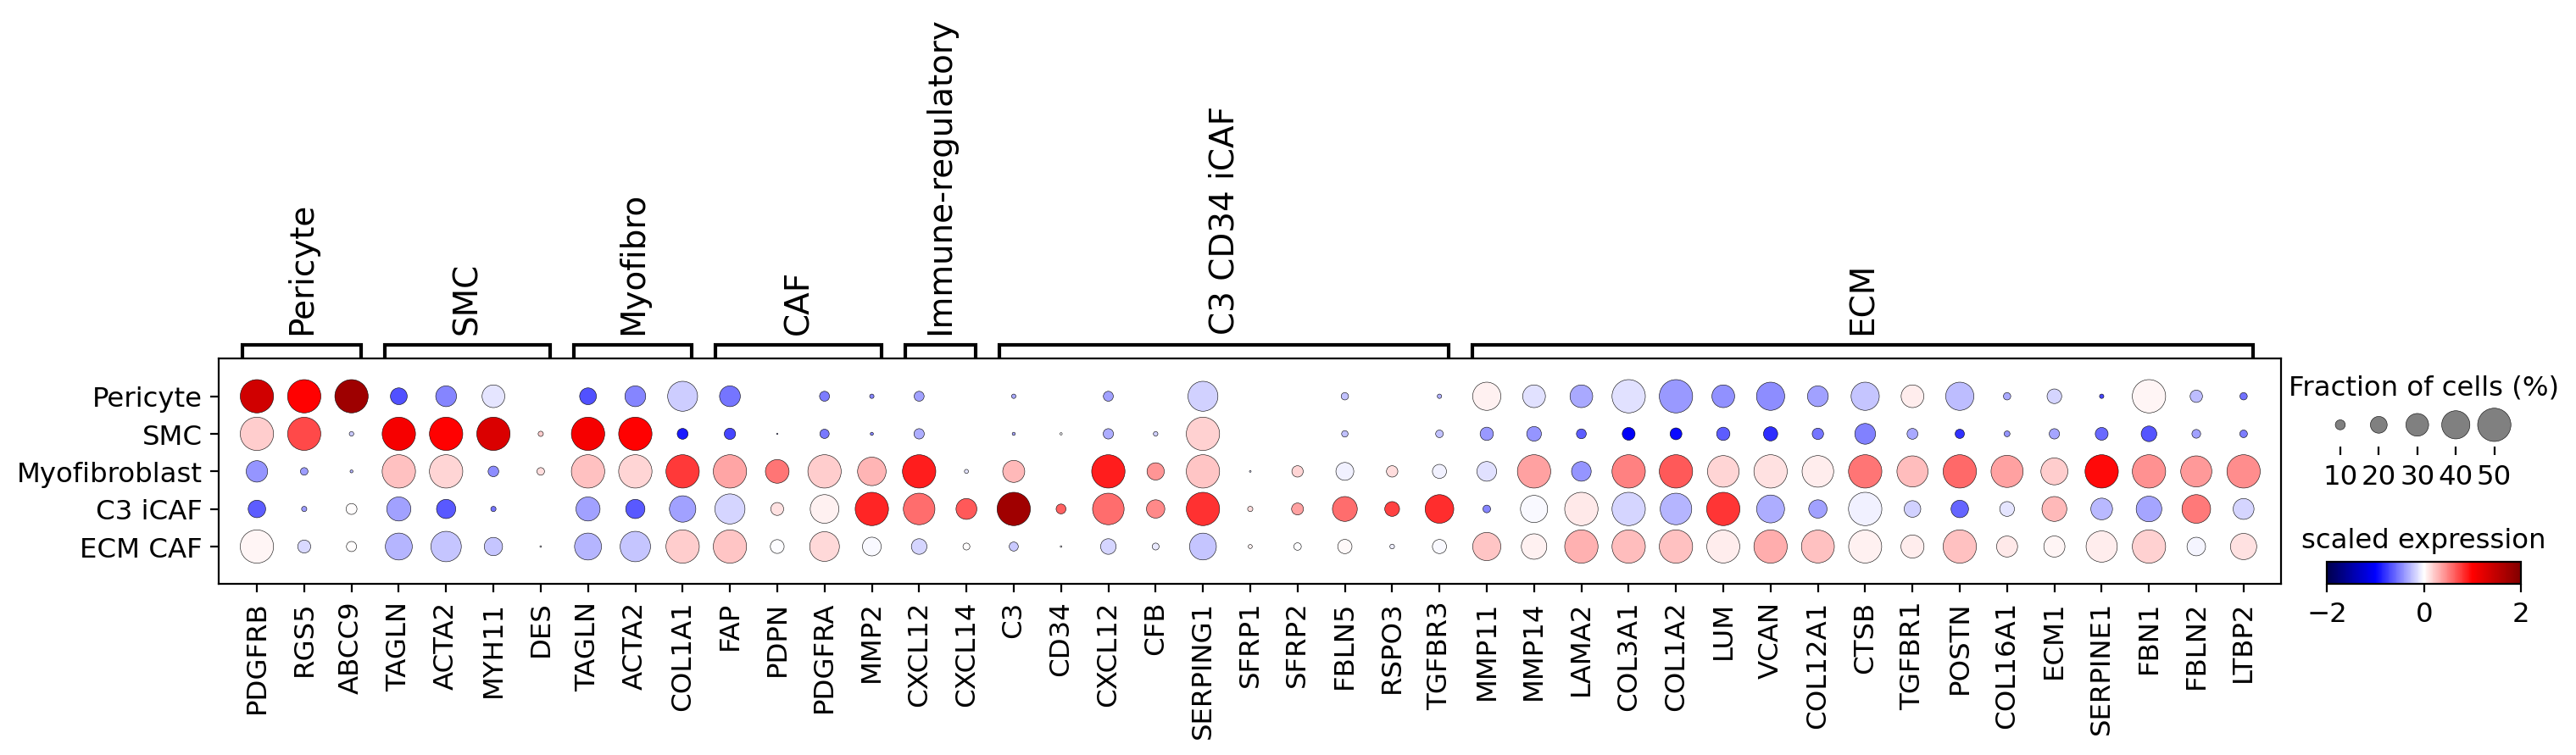

In [35]:
sc.pl.dotplot(adata=adata_zscore, 
              var_names=markers,
              categories_order=["Pericyte", "SMC", "Myofibroblast", "C3 iCAF", "ECM CAF"
                     ],
              groupby="Annotation_scVI_detailed",
              cmap="seismic", 
              layer="scaled", 
              vmin=-2,
              vmax=2, 
              dot_max=0.5, 
              colorbar_title = "scaled expression", 
              size_title="Fraction of cells (%)",
              save='zscore_general.pdf')

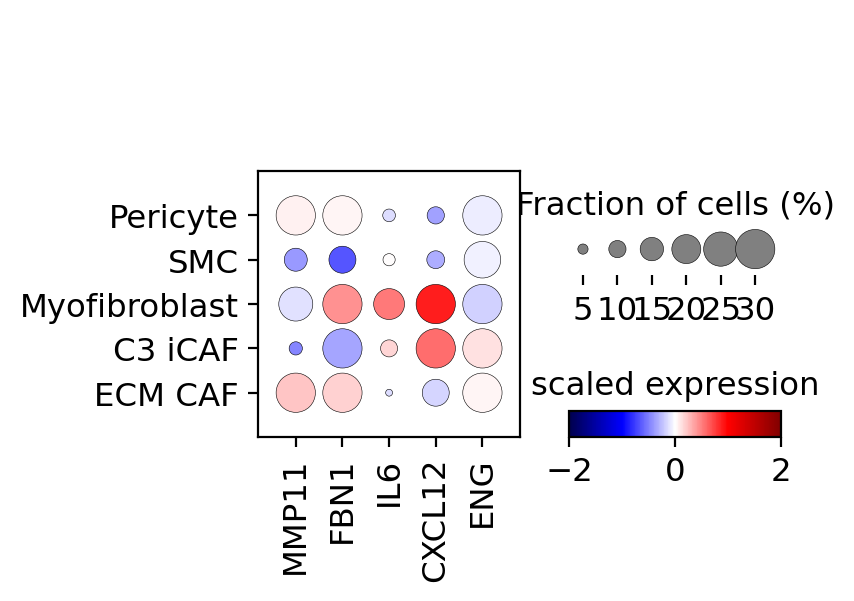

In [16]:
markers_v2 = ["MMP11", "FBN1", "IL6", "CXCL12", "ENG"]
sc.pl.dotplot(adata=adata_zscore, 
              var_names=markers_v2,
              categories_order=["Pericyte", "SMC", "Myofibroblast", "C3 iCAF", "ECM CAF"
                     ],
              groupby="Annotation_scVI_detailed",
              cmap="seismic", 
              layer="scaled", 
              vmin=-2,
              vmax=2, 
              dot_max=0.3, 
              colorbar_title = "scaled expression", 
              size_title="Fraction of cells (%)",
              save='zscore_general_v2.pdf')

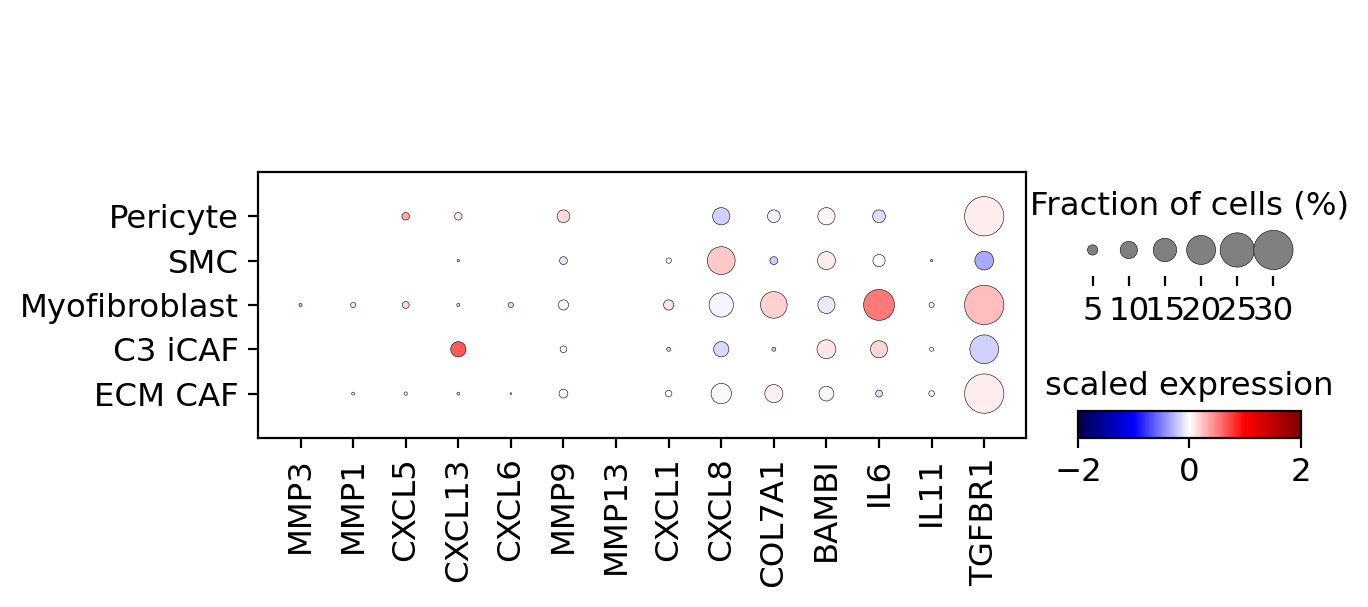

In [17]:
sc.pl.dotplot(adata=adata_zscore, 
              var_names=markers_specific_caf["MMP"],
              categories_order=["Pericyte", "SMC", "Myofibroblast", "C3 iCAF", "ECM CAF"
                     ],
              groupby="Annotation_scVI_detailed",
              cmap="seismic", 
              layer="scaled", 
              vmin=-2,
              vmax=2, 
              dot_max=0.3, 
              colorbar_title = "scaled expression", 
              size_title="Fraction of cells (%)",
              save='zscore_general_MMP.pdf')

ECM CAF:  ECM CAFs (mCAFs), expressing low levels of ACTA2 but high levels of ECM-associated genes
#### including various collagens, MMP11, MMP2, MMP14, PDGFRA, LAMA2, COL3A1, COL1A2, LUM, DCN and VCAN

8


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


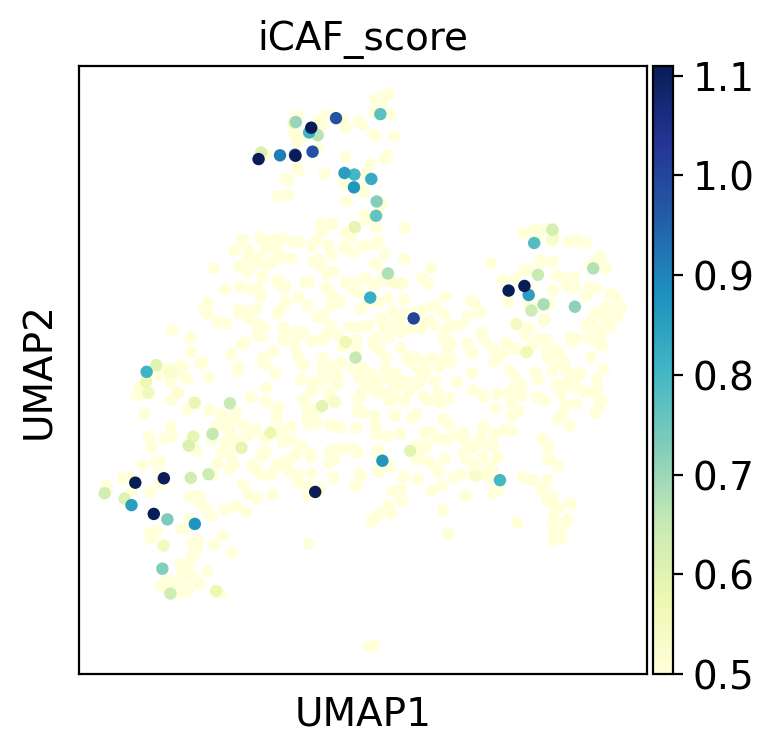

length of gene list in adata.var: 8
8


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


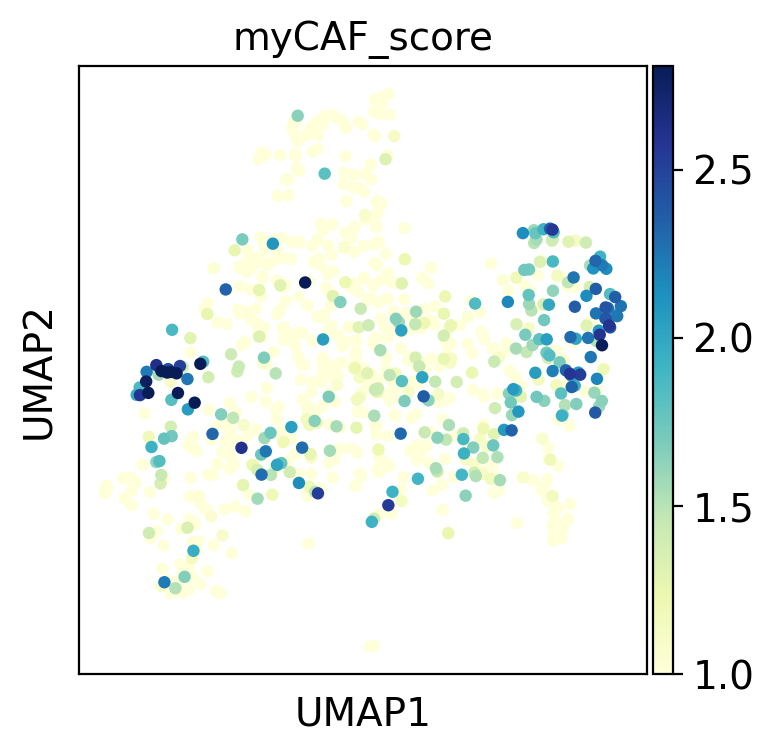

length of gene list in adata.var: 8


In [18]:
# from https://aacrjournals.org/cancerdiscovery/article/9/8/1102/42174/Cross-Species-Single-Cell-Analysis-of-Pancreatic
icaf_markers = ["IL6", "CXCL12", "CFD", "DPT", "LMNA", "CXCL2", "CCL2", "IL1R1"]
mycaf_markers = ["ACTA2", "TAGLN", "MMP11", "MYL9", "HOPX", "POSTN", "TPM1", "TPM2"]

# see https://aacrjournals.org/cancerdiscovery/article/9/2/282/10645/IL1-Induced-JAK-STAT-Signaling-Is-Antagonized-by

# score for iCAFs and myCAFs
print(len(icaf_markers))
icaf_markers_var = [
    gene for gene in icaf_markers if gene in adata.raw.to_adata().var_names
]
sc.tl.score_genes(
    adata, gene_list=icaf_markers_var, score_name="iCAF_score", use_raw=True
)
sc.pl.umap(
    adata,
    color="iCAF_score",
    vmax="p99",
    use_raw=True,
    vmin=0.5,
    save="iCAF_score.pdf",
    size=80,
    show=True,
    color_map="YlGnBu",
)
print("length of gene list in adata.var:", len(icaf_markers_var))


print(len(mycaf_markers))
mycaf_markers_var = [
    gene for gene in mycaf_markers if gene in adata.raw.to_adata().var_names
]
sc.tl.score_genes(
    adata, gene_list=mycaf_markers_var, score_name="myCAF_score", use_raw=True
)
sc.pl.umap(
    adata,
    color="myCAF_score",
    vmax="p99",
    use_raw=True,
    vmin=1,
    save="myCAF_score.pdf",
    size=80,
    show=True,
    color_map="YlGnBu",
)
print("length of gene list in adata.var:", len(mycaf_markers_var))